# Emcee subfit
16 November 2019

Now that we've shown that `emcee` can work, given that we initialize all the walkers near the correct lens value, let's try to use it to fit subhalos!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import emcee

# Generate original image

In [2]:
# some standard python imports #
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cms
#%matplotlib inline

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
import lenstronomy.Plots.output_plots as lens_plot
from lenstronomy.LightModel.light_model import LightModel
import lenstronomy.Util.param_util as param_util
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.psf import PSF
import lenstronomy.Util.image_util as image_util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

import copy

In [3]:
def ADD(z1,z2):
    ## This is a function that computes the angular diameter distance
    ## between two redshifts z1 and z2.
    cosmo = FlatLambdaCDM(H0=70, Om0=0.316) 
    return cosmo.angular_diameter_distance_z1z2(z1,z2)

def sigma_cr(zd,zs):
    ## This function calculates the critical surface mass density at
    ## redshift zd, relative to the source redshift zs.
    const = 1.663e18*u.M_sun / u.Mpc##c^2/(4 pi G)
    return const*(ADD(0,zs)/(ADD(zd,zs)*ADD(0,zd))) ##in units Msun/Mpc^2

def gfunc(c):
    ## This is the g(c) function that is defined
    ## commonly in NFW profiles.
    a = np.log(1.+c) - (c/(1.+c))
    return 1./a

def rs_angle(zd,rs): 
    ##takes in interloper redshift, gives you the scale redius in angular units
    Dd = ADD(0,zd)
    rs_mpc = rs*u.Mpc
    return ((1./4.848e-6)*rs_mpc)/Dd ##gives in arcsec

def alpha_s(m,rs,zd,zs):
    ##takes in subhalo mass, scale radius, interloper redshift, source redshift
    ##returns the angular deflection at scale radius
    m_msun = m*u.M_sun
    rs_mpc = rs*u.Mpc
    con = (1./np.pi)*gfunc(200.)*(1.-np.log(2))
    return m_msun/((rs_mpc**2.)*sigma_cr(zd,zs))

def k_ext(N,m,A,zd,zs,pixsize):
    ## FOR NOW THIS IS SET TO ZERO BECAUSE I CAN'T GET IT TO WORK
    m_msun = m*u.M_sun
    A_mpc2 = (pixsize**4)*(ADD(0.,zd)**2.)*A*((4.848e-6)**2.)  ##arcsec conversion
    return 0.##-(N*m_msun)/(A_mpc2*sigma_cr(zd,zs))


def xi_to_x(xi,z):
    ##takes in physical coordinates (Mpc), turns it into angular coordinates (arcsec)
    x = np.array(((xi*u.Mpc)/ADD(0.,z))/4.848e-6)
    y = x.astype(np.float)
    return y

def x_to_xi(x,z):
    ##takes in angular coordinates (arcsec), turns it into physical coordinates (Mpc)
    return ((x*4.848e-6)*ADD(0,z))/u.Mpc

def xi_to_pix(xi,z,pixsize,pixnum):
    ## takes in physical coordinates (Mpc), identifies the appropriate pixel number
    return (xi_to_x(xi,z))/pixsize + pixnum/2.

**Image-generation parameters**

In [7]:
## REDSHIFTS #######################################################################################
Nit = 100 ##Number of different redshifts
zds = np.linspace(0.01,0.99,Nit)
####################################################################################################



## SOURCE PROPERTIES ###############################################################################
r_sersic_source = 10.0
e1s, e2s = param_util.phi_q2_ellipticity(phi=0.8, q=0.2)
beta_ras, beta_decs = [1.7],[0.3]#this is the source position on the source plane

n_sersic_source = 1.5

## SOURCE-CLUMP PROPERTIES #########################################################################
r_sersic_source_clumps = 1/3.
N_clump = 0
clumprandx = np.random.rand(N_clump)
clumprandy = np.random.rand(N_clump)

source_scatter = 1. ## This is how wide the scatter of the clumps over the smooth source

n_sersic_source_clumps = 1.5

####################################################################################################



## LENS PROPERTIES #################################################################################
theta_lens = 10.
zl = 0.2
r_theta_lens = x_to_xi(theta_lens,zl)
e1, e2 = param_util.phi_q2_ellipticity(phi=-0.9, q=0.8)
gamma = 2.

center_lens_x, center_lens_y = 0.,0.
####################################################################################################



## IMAGE PROPERTIES ################################################################################
pixsize = 0.2
####################################################################################################



## INTERLOPER PROPERTIES ########################################################################### 
N = 1 ##Number of perturbers
M = 1 ##Averaging different realizations

disc_size = 2. ##  interlopers are randomly distributed to a disk that is this
               ##  this times bigger than the einstein radius of the lens
# Perturbers are uniformly distributed within a disk of radius `disc_size * r_theta_lens`
r2s = ((disc_size*r_theta_lens)**2.)*(np.random.rand(N,M))
rss = np.sqrt(r2s)
theta_p = 2.*np.pi*(np.random.rand(N,M))
xs = rss*np.cos(theta_p)
ys = rss*np.sin(theta_p)
xpixs = np.zeros([Nit,N,M]) # will add pixel values in the next cell
ypixs = np.zeros([Nit,N,M]) #
####################################################################################################

## Specific image $-$ choose `j`, `k`
Note that we'll be choosing one specific redshift and one specific statistic for now.

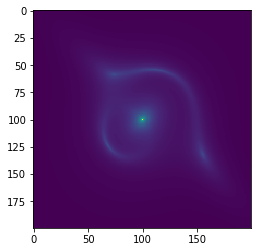

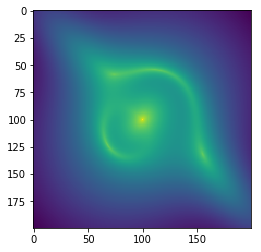

In [8]:
j = 19 # arbitrary choice (loop over redshifts)
k = 0 # also arbitrary choice (loop over statistics)

beta_ra, beta_dec = beta_ras[0], beta_decs[0]

xpixs[j] = xi_to_pix(xs,zds[j],pixsize,200)   ## AT THAT REDSHIFT CALCULATING THE INTERLOPER
ypixs[j] = xi_to_pix(ys,zds[j],pixsize,200)   ## POSITIONS. (THEY ARE RANDOMLY GENERATED IN THE EARLIER BOX)

m =1.0e7 # mass of interlopers
if j == 0:
    m = 0. # so that the first image will be pure (no interloper effect)
zs = 1.
zd = zds[j] # interloper redshift
rs = 0.001  # interloper scale radius r_s
A = 80**2 ## in arcsec ## IGNORE THIS, THIS WAS FOR NEGATIVE CONVERGENCE

kext = float(k_ext(N,m,A,zl,zs,pixsize))
rsang = float(rs_angle(zd,rs))
alphars = float(alpha_s(m,rs,zd,zs))

## Setting lens_model_list and redshift_list
lens_model_main = ['SPEP']
lens_model_interlopers = ['CONVERGENCE']+['NFW' for i in range(N)]
redshift_main = [zl]
redshift_interlopers = [zd]+[zd for i in range(N)]
# (unfortunately, we need to give the redshifts in increasing order, so we have two cases)
if zl >= zd:
    lens_model_list = lens_model_interlopers + lens_model_main
    redshift_list = redshift_interlopers + redshift_main
else:
    lens_model_list = lens_model_main + lens_model_interlopers
    redshift_list = redshift_main + redshift_interlopers


z_source = zs

lensModel_mp = LensModel(lens_model_list=lens_model_list,
                         z_source=z_source,
                         lens_redshift_list=redshift_list, 
                         multi_plane=True)

kwargs_spep = {'theta_E': theta_lens, 'e1': e1, 'e2': e2, 
               'gamma': gamma, 'center_x': center_lens_x, 'center_y': center_lens_y}
kwargs_conv ={'kappa_ext': kext}

### NFW kwargs for the interlopers
kwargs_main_lens = [kwargs_spep]
kwargs_interlopers = [kwargs_conv] # (+ will append interlopers)
for i in range(N):
    center_nfw_x = xi_to_x(xs[i,k],zd)
    center_nfw_y = xi_to_x(ys[i,k],zd)

    kwargs_nfw = {'Rs':rsang,'alpha_Rs':alphars,'center_x': center_nfw_x, 'center_y': center_nfw_y}
    kwargs_interlopers.append(kwargs_nfw)

# (again, need to sort by redshift)
if zl >= zd:
    kwargs_lens = kwargs_interlopers + kwargs_main_lens
else:
    kwargs_lens = kwargs_main_lens + kwargs_interlopers

########################################################################
# set up the list of light models to be used #

# SOURCE light
source_light_model_list = ['SERSIC_ELLIPSE']
for i in range(N_clump):
    source_light_model_list.append('SERSIC')

lightModel_source = LightModel(light_model_list = source_light_model_list)

# LENS light
lens_light_model_list = ['SERSIC_ELLIPSE']
lightModel_lens = LightModel(light_model_list = lens_light_model_list)

# SOURCE light kwargs
kwargs_light_source = [{'amp': 1000., 'R_sersic': r_sersic_source, 'n_sersic': n_sersic_source, 
                      'e1': e1s, 'e2': e2s, 'center_x': beta_ra , 'center_y': beta_dec}]
for i in range(N_clump):
    kwargs_light_source.append({'amp': 1000, 'R_sersic': r_sersic_source_clumps, 'n_sersic': n_sersic_source_clumps,
                                'center_x': beta_ra+source_scatter*(clumprandx[i]-.5), 
                                'center_y': beta_dec+source_scatter*(clumprandy[i]-.5)})

# LENS light kwargs
kwargs_light_lens = [{'amp': 1500, 'R_sersic': theta_lens, 'n_sersic': gamma, 
                      'e1': e1, 'e2': e2, 'center_x': center_lens_x , 'center_y': center_lens_y}]

# evaluate surface brightness at a specific position #
#flux = lightModel_lens.surface_brightness(x=1, y=1, kwargs_list=kwargs_light_lens)

deltaPix = pixsize ###aLSO PIXSIze size of pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
ra_at_xy_0, dec_at_xy_0 = -20, -20 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': 200, 'ny': 200,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates
# compute pixel value of a coordinate position #
x_pos, y_pos = pixel_grid.map_coord2pix(ra=0, dec=0)
# compute the coordinate value of a pixel position #
ra_pos, dec_pos = pixel_grid.map_pix2coord(x=20, y=10)

# import the PSF() class #

kwargs_psf = {'psf_type': 'GAUSSIAN',  # type of PSF model (supports 'GAUSSIAN' and 'PIXEL')
              'fwhm': 0.01,  # full width at half maximum of the Gaussian PSF (in angular units)
              'pixel_size': deltaPix  # angular scale of a pixel (required for a Gaussian PSF to translate the FWHM into a pixel scale)
             }
psf = PSF(**kwargs_psf)
# return the pixel kernel correspon
kernel = psf.kernel_point_source

####################################################################################

# import the ImageModel class #

# define the numerics #
kwargs_numerics = {'supersampling_factor': 1, # each pixel gets super-sampled (in each axis direction) 
                  'supersampling_convolution': False}
# initialize the Image model class by combining the modules we created above #
imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel_mp,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        kwargs_numerics=kwargs_numerics)
# simulate image with the parameters we have defined above #
image = imageModel.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source,
                         kwargs_lens_light=kwargs_light_lens)#, kwargs_ps=kwargs_ps)

plt.imshow(image); plt.show()
plt.imshow(np.log(image)); plt.show()

In principle, we would make the image noisy here, but we'll skip that step for now.

# Define lens model of fit